<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 5</h1>

In questo notebook sono riportati gli esercizi per la cui soluzione è necessario il codice **md.5**: i grafici qui presenti sono in python, ma nella cartella è possibile trovarne di analoghi fatti con gnuplot. Sono anche riportati i comandi per creare i plot, salvati in dei file '.gnuplot'. 

Per eseguire il notebook sui computer di laboratorio, è necessario lanciare il seguente comando e selezionare un kernel python.

<center>

`module load python3/anaconda`
<center>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

from scipy.stats import norm
from scipy.optimize import curve_fit

<center>

## Termostato di Langevin
</center>

L'approccio della lezione **md.4** per includere gli effetti legati all'ambiente circostante la molecola era di risolvere le equazioni della dinamica anche per gli atomi del fluido. Questo approccio, anche se si utilizzano espedienti come il raggio di cutoff, è computazionalmente dispendioso e non necessario, poichè quello che realmente ci interessa è l'effetto complessivo sul sistema che stiamo analizzando. Se il moto degli atomi di fluido è scorrelato a quello della molecola, possiamo trascurare la loro dinamica con la semplice assunzione che il sistema che noi stiamo analizzando non è più micro-canonico, ossia ad energia costante, ma a temperatura costante. Gli effetti del fluido sono racchiusi in un bagno termico, che influenza la dinamica della molecola. Un modo di simulare un ensamble canonico è per mezzo delle equazioni di Langevin, in cui la posizione e le sue derivate temporali sono legate come

$$
m_i\frac{d\vec{v_i}}{dt}\,=\,\vec{f_i}\left(t\right)\,-\,\gamma\vec{v_i}\left(t\right)\,+\,\vec{\eta}\left(t\right)
$$

Il termine lineare nella velocità tiene conto dell'attrito viscoso del fluido, dove il coefficiente gamma è approssimato dalla legge di Stokes

$$
\gamma\,=\,6\pi\eta_F R
$$

L'ultimo termine presente nella relazione precedente è una forza sotcastica, che è necesasria per riprodurre gli urti casuali con le molecole costituenti il fluido. 

## Velocity Verlet Langevin Dynamics

L'algoritmo **Velocity Verlet** può essere riformulato, in presenza di un termostato di Langevin, come

<br>

$$
v\left(t\,+\,\frac{\Delta t}{2}\right)\,=\,\left(1\,-\,\gamma\frac{\Delta t}{2m}\right)v(t)\,+\,\frac{\Delta t}{2m}\left[f(t)\,+\,\eta(t)\right]
$$

<br>

$$
r(t\,+\,\Delta t)\,=\,r(t)\,+\,v\left(t\,+\,\frac{\Delta t}{2}\right)\Delta t
$$

<br>

$$
v(t\,+\,\Delta t)\,=\,\frac{1}{1\,+\,\gamma \Delta t/2m}\left\{v\left(t\,+\,\frac{\Delta t}{2}\right)\,+\,\frac{\Delta t}{2m}\left[f(t\,+\,\Delta t)\,+\,\eta (t\,+\,\Delta t)\right]\right\}
$$

<center>
<h1 style="color:blue; font-size:50px;"> Esercizio 2.7</h1>

L'obiettivo dell'esercizio è testare come vari il tempo di termalizzazione in base al valore della costante d'attrito fornita come input della simulazione. Ho deciso di lavorare con cinque valori di gamma differenti

$$
\gamma \in \left\{0.5,\,0.75,\,1,\,1.25,\,1.5\right\}
$$

Ho scritto un semplice script, *termG.sh*, per automatizzare la modifica del valore di gamma e l'esecuzione del programma. In seguito riporto il confronto fra i cinque andamenti ottenuti, ed il valore imposto dai parametri simulativi, pari a

$$
T\,=\,100\,\text{K}
$$

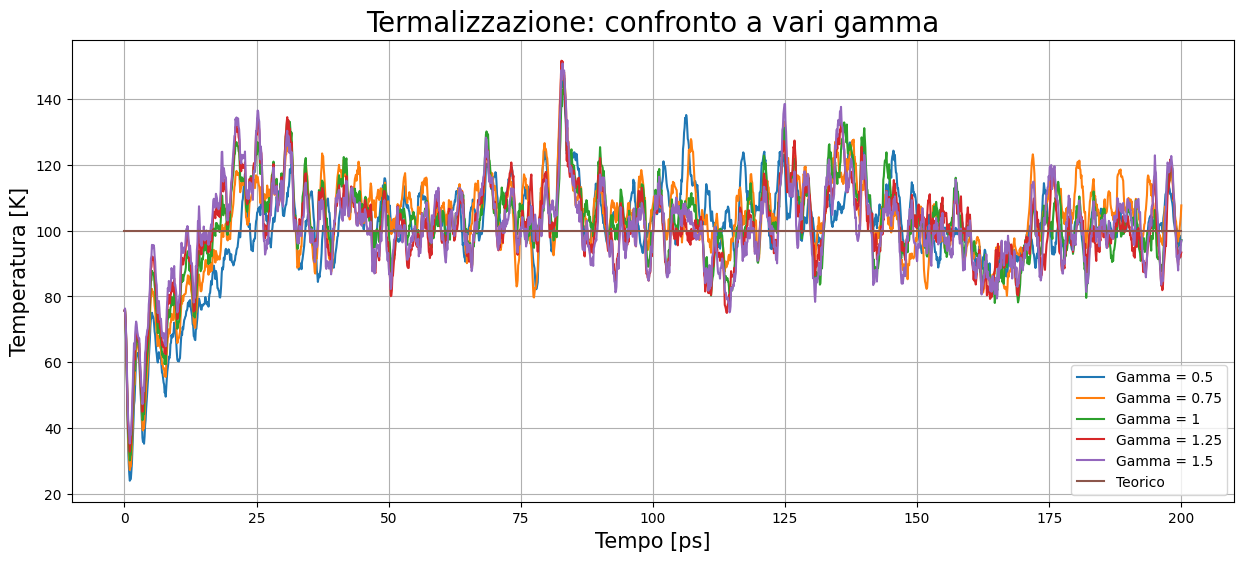

In [2]:
fig = plt.figure(figsize=(15, 6))
gamma = np.array(['0.5', '0.75', '1', '1.25', '1.5'])

for i in gamma:
    res = np.loadtxt('termG/term' + i + '.out')
    plt.plot(res[:, 0], res[:, 5], label = 'Gamma = ' + i)

plt.plot(np.array([res[0, 0], res[-1, 0]]), np.array([100, 100]), label = 'Teorico')
plt.ylabel(r"Temperatura [K]", fontsize = 15)
plt.xlabel(r"Tempo [ps]", fontsize = 15)
plt.title(r"Termalizzazione: confronto a vari gamma", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

plt.show()

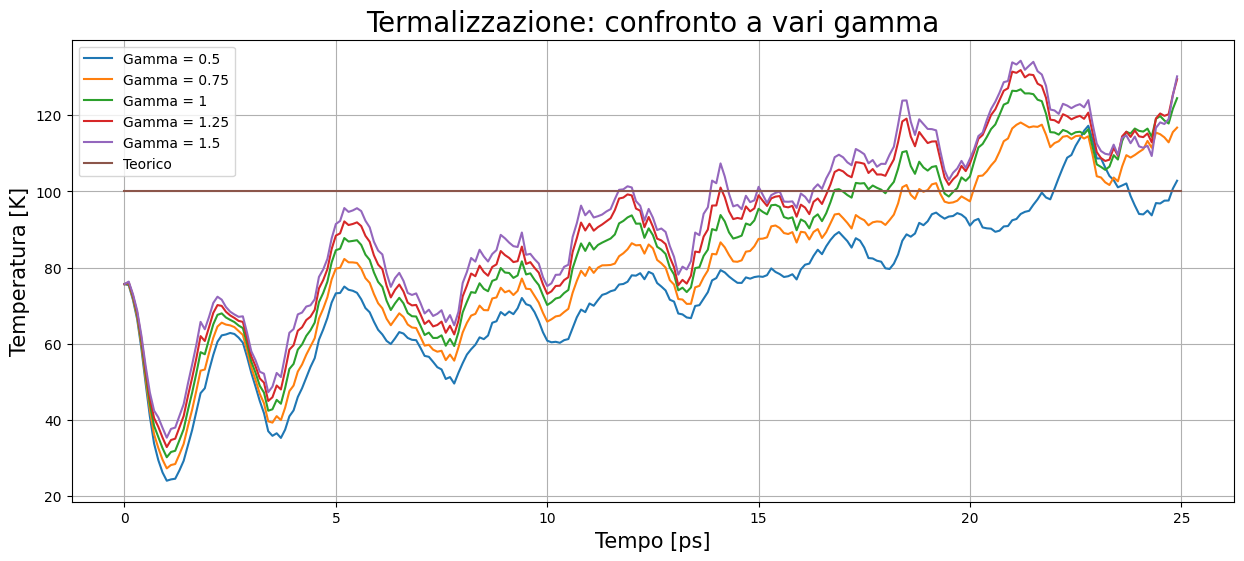

In [3]:
fig = plt.figure(figsize=(15, 6))
gamma = np.array(['0.5', '0.75', '1', '1.25', '1.5'])

for i in gamma:
    res = np.loadtxt('termG/term' + i + '.out')
    plt.plot(res[0:250, 0], res[0:250, 5], label = 'Gamma = ' + i)

plt.plot(np.array([res[0, 0], res[250, 0]]), np.array([100, 100]), label = 'Teorico')
plt.ylabel(r"Temperatura [K]", fontsize = 15)
plt.xlabel(r"Tempo [ps]", fontsize = 15)
plt.title(r"Termalizzazione: confronto a vari gamma", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

plt.show()

Possiamo notare come a gamma maggiori corrisponda una termalizzazione più contenuta. Quantificare la fase di transiente è fondamentale per ottenere stime degli osservabili che riflettano l'equilibrio termodinamico ricercato nel sistema in analisi. 

<center>
<h1 style="color:blue; font-size:50px;"> Esercizio 2.8</h1>

L'obiettivo dell'esercizio è la caratterizzazione del decadimento della temperatura in funzione del tempo, nel momento in cui la temperatura dell'ensamble è fissata a zero. Vogliamo provare a fittare la caduta della temperatura misurata con una funzione esponenziale del tipo

$$
a\exp{\left(-t/b\right)}
$$

Per valutare quale sia la dipendenza dai parametri simulativi, consideriamo diversi valori di massa dei costituenti e di fattori gamma. In particolare, ho lavorato con tutte le possibili combinazioni fra

$$
m \in \left\{5,\,7.5,\,10,\,12.5,\,15\right\}
$$

$$
\gamma \in \left\{0.5,\,0.75,\,1,\,1.25,\,1.5\right\}
$$

Riporto in primo luogo il fit effettato con 

$$
\begin{cases}
    m\,=\,10\\
    \gamma\,=\,1.0
\end{cases}
$$

In [4]:
def exp_model(x, a, b):
    return a * np.exp(-x/b)

Il fattore moltiplicativo dell'esponenziale è pari a 38.492 K
Il tempo caratteristico risulta essere 10.051 ps


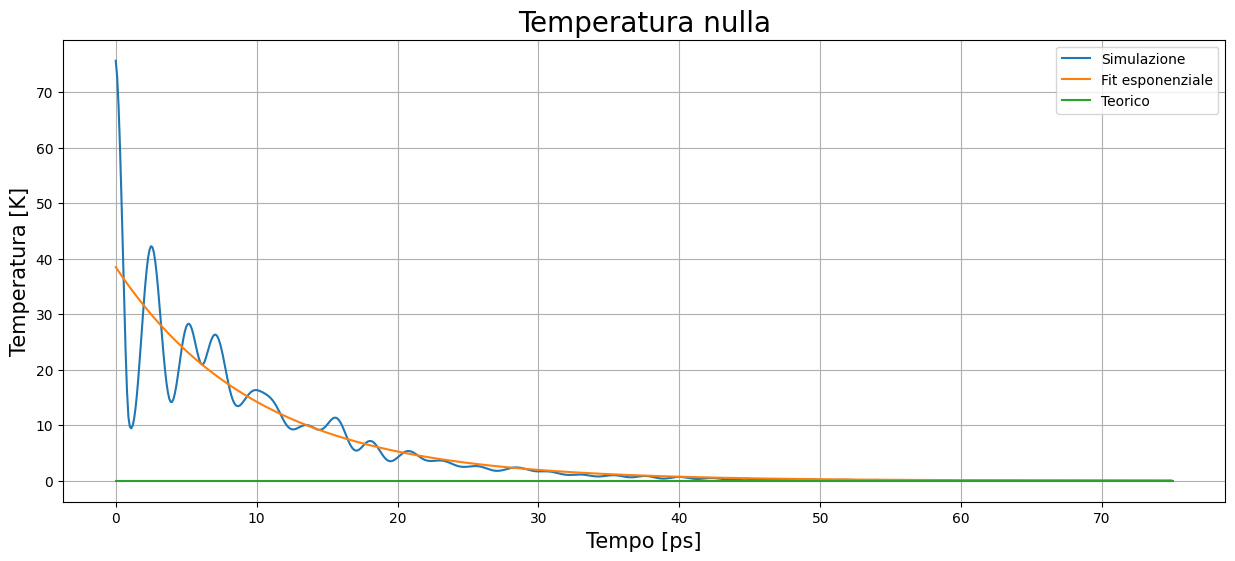

In [5]:
fig = plt.figure(figsize=(15, 6))

res = np.loadtxt('nullT/nullT.out')
plt.plot(res[0:750, 0], res[0:750, 5], label = 'Simulazione')

#-------------------------------#
#       Fit esponenziale        #
#-------------------------------#
params, covariance = curve_fit(exp_model, res[0:750, 0], res[0:750, 5])
a = params[0]
b = params[1]
y_fit = exp_model(res[0:750, 0], a, b)

print("Il fattore moltiplicativo dell'esponenziale è pari a " + str(round(a, 3)) + " K")
print("Il tempo caratteristico risulta essere " + str(round(b, 3)) + " ps")

plt.plot(res[0:750, 0], y_fit, label = 'Fit esponenziale')
plt.plot(np.array([res[0, 0], res[750, 0]]), np.array([0, 0]), label = 'Teorico')
plt.ylabel(r"Temperatura [K]", fontsize = 15)
plt.xlabel(r"Tempo [ps]", fontsize = 15)
plt.title(r"Temperatura nulla", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

plt.show()

Provo ora a valutare quanto accade mantenendo fissata la massa dei costituenti, pari a

$$
m\,=\,10
$$

ed andando a variare il valore della costante gamma. Ho preso in considerazione i cinque valori già utilizzati per l'esercizio precedente, che riporto per completezza

$$
\gamma \in \left\{0.5,\,0.75,\,1,\,1.25,\,1.5\right\}
$$

Noto una dipendenza sul tempo caratteristico di smorzamento della temperatura, che è maggiore quanto più piccolo è gamma. Tale comportamento riflette la dipendenza che la durata del transiente ha su gamma poichè, come abbiamo osservato in precedenza, i tempi di termalizzazione minori si hanno per gamma grandi. Il fattore moltiplicativo dell'esponenziale è circa lo stesso per i vari fit, dato che è legato alla condizione iniziale della simulazione.


Il fattore moltiplicativo dell'esponenziale con gamma = 0.5 è pari a 39.568 K
Il tempo caratteristico con gamma = 0.5 risulta essere 19.817 ps

Il fattore moltiplicativo dell'esponenziale con gamma = 0.75 è pari a 38.721 K
Il tempo caratteristico con gamma = 0.75 risulta essere 13.378 ps

Il fattore moltiplicativo dell'esponenziale con gamma = 1 è pari a 38.492 K
Il tempo caratteristico con gamma = 1 risulta essere 10.051 ps

Il fattore moltiplicativo dell'esponenziale con gamma = 1.25 è pari a 38.579 K
Il tempo caratteristico con gamma = 1.25 risulta essere 7.977 ps

Il fattore moltiplicativo dell'esponenziale con gamma = 1.5 è pari a 39.031 K
Il tempo caratteristico con gamma = 1.5 risulta essere 6.507 ps



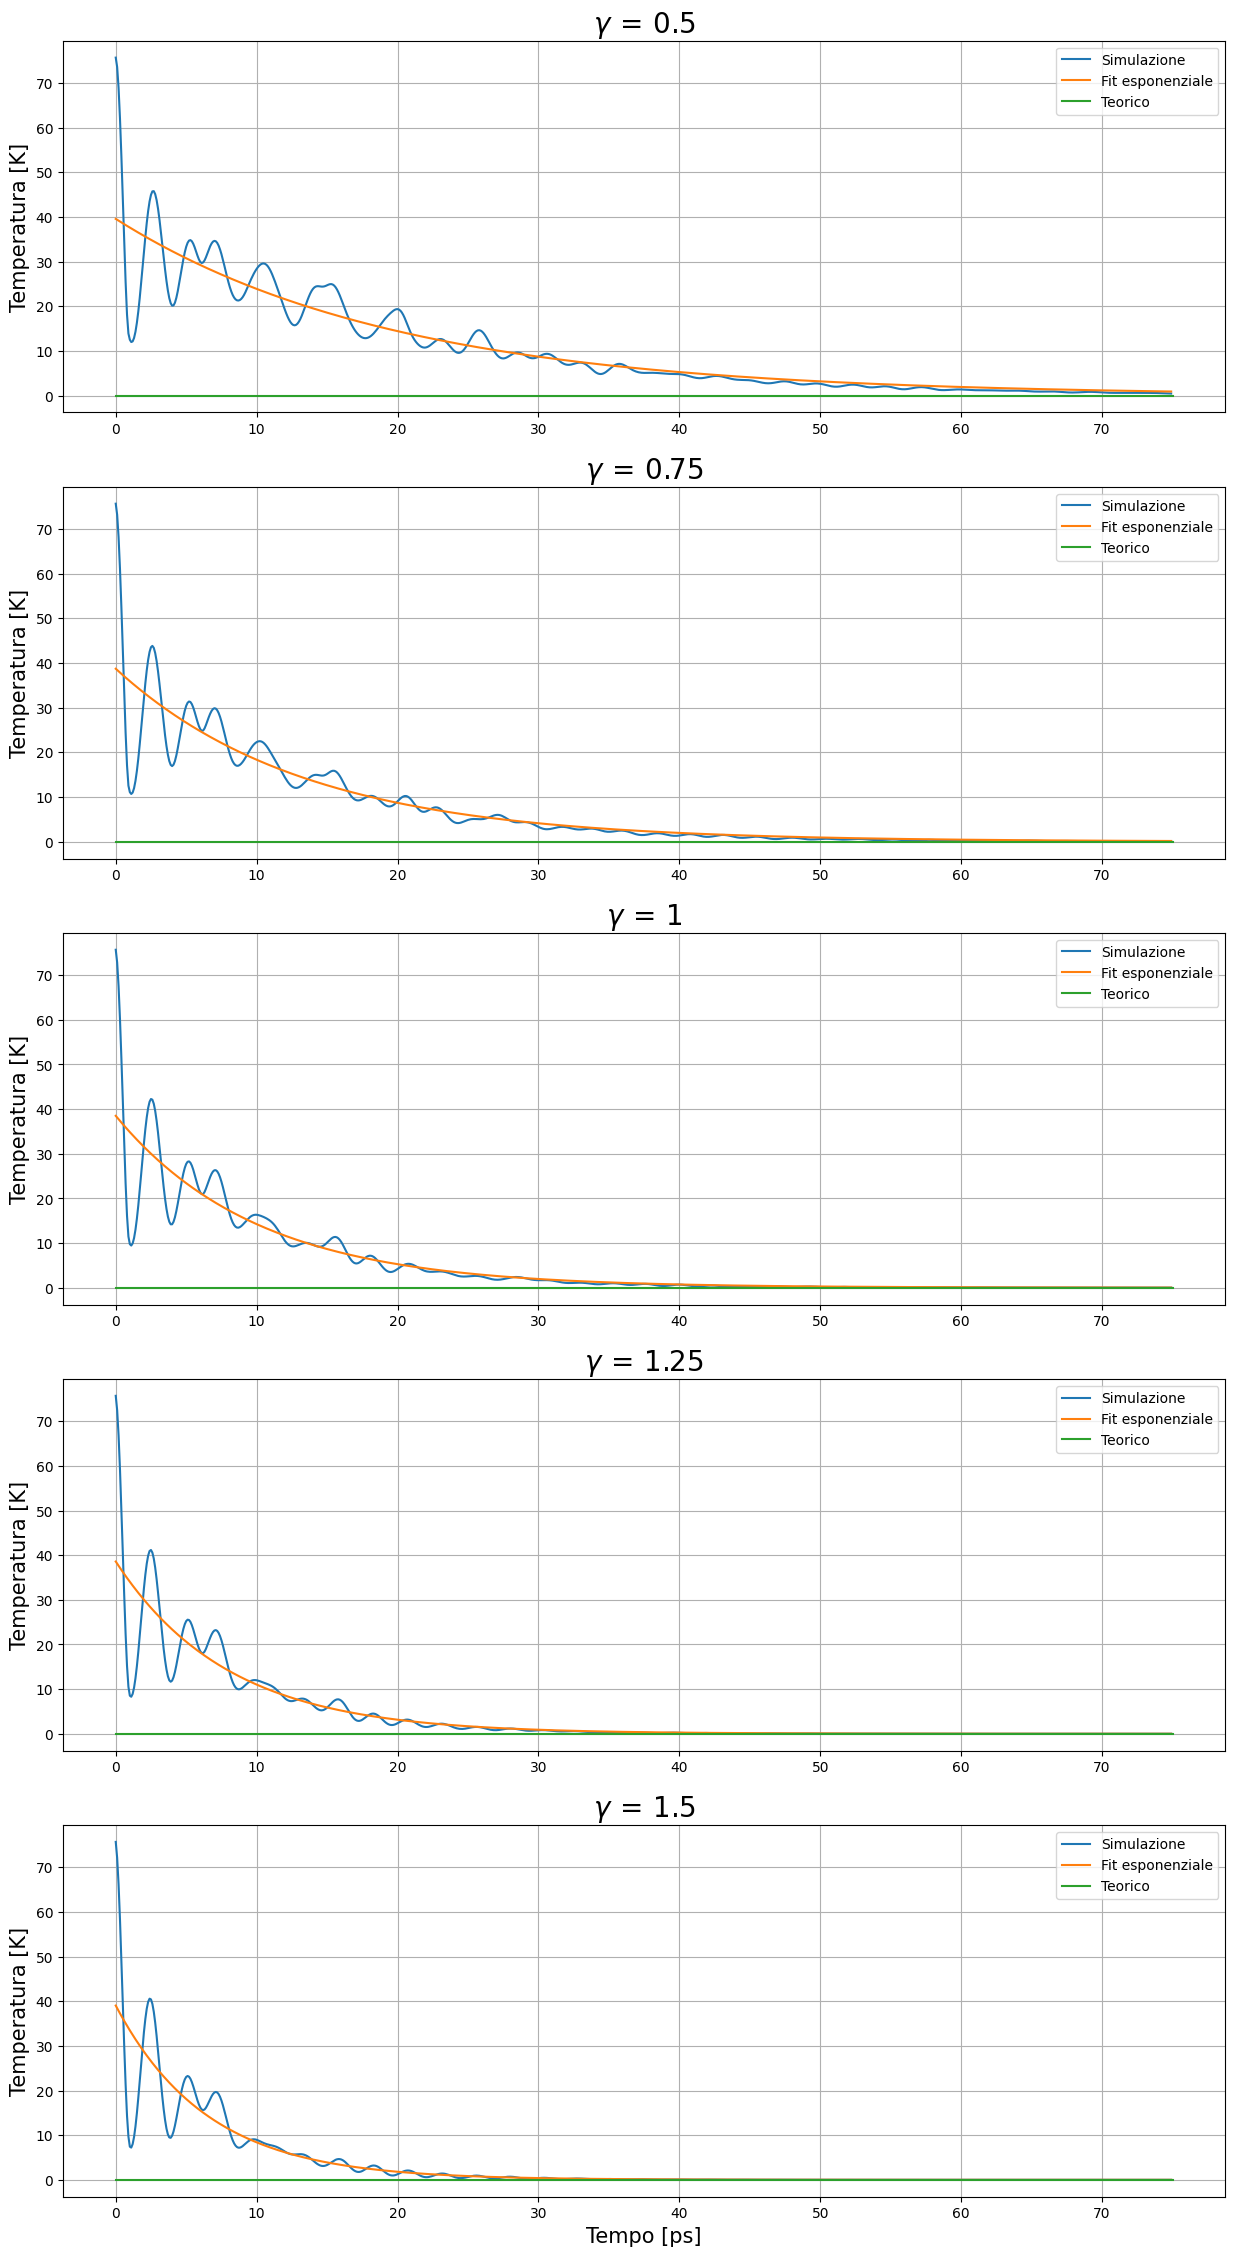

In [6]:
fig, axs = plt.subplots(5, 1, figsize=(15, 28))
gamma = np.array(['0.5', '0.75', '1', '1.25', '1.5'])
conta = -1

for i in gamma:
    conta += 1
    ax = axs[conta]
    res = np.loadtxt('nullT/fit_g' + i + '-m10.out')
    ax.plot(res[0:750, 0], res[0:750, 5], label = 'Simulazione')

    #-------------------------------#
    #       Fit esponenziale        #
    #-------------------------------#
    params, covariance = curve_fit(exp_model, res[0:750, 0], res[0:750, 5])
    a = params[0]
    b = params[1]
    y_fit = exp_model(res[0:750, 0], a, b)

    print("Il fattore moltiplicativo dell'esponenziale con gamma = " + i + " è pari a " + str(round(a, 3)) + " K")
    print("Il tempo caratteristico con gamma = " + i + " risulta essere " + str(round(b, 3)) + " ps")
    print("")

    ax.plot(res[0:750, 0], y_fit, label = 'Fit esponenziale')
    ax.plot(np.array([res[0, 0], res[750, 0]]), np.array([0, 0]), label = 'Teorico')
    
    ax.set_ylabel(r"Temperatura [K]", fontsize = 15)
    ax.set_title(r"$\gamma\,=\,$" + i, fontsize = 20)
    
    ax.grid(True)
    ax.legend(loc = 'best')

ax.set_xlabel(r"Tempo [ps]", fontsize = 15)
plt.show()

Provo ora a valutare quanto accade mantenendo fissa la costante gamma, pari a

$$
\gamma\,=\,1
$$

ed andando a variare la massa dei costituenti. Ho preso in considerazione i seguenti cinque valori

$$
m \in \left\{5,\,7.5,\,10,\,12.5,\,15\right\}
$$

Notiamo che al variare della massa varia anche il fattore moltiplicativo dell'esponenziale, che è fissato dalla condizione iniziale. Chiaramente all'aumentare della massa dei costituenti, ma mantenendo la velocità degli stessi costante, aumenta anche la temperatura della catena. Osserviamo anche una dipendenza sul tempo caratteristico di smorzamento, tale per cui all'aumentare della massa aumenta anche tale quantità.

Il fattore moltiplicativo dell'esponenziale con massa = 5 è pari a 20.779 K
Il tempo caratteristico con massa = 5 risulta essere 4.451 ps

Il fattore moltiplicativo dell'esponenziale con massa = 7.5 è pari a 30.31 K
Il tempo caratteristico con massa = 7.5 risulta essere 6.946 ps

Il fattore moltiplicativo dell'esponenziale con massa = 10 è pari a 38.492 K
Il tempo caratteristico con massa = 10 risulta essere 10.051 ps

Il fattore moltiplicativo dell'esponenziale con massa = 12.5 è pari a 47.679 K
Il tempo caratteristico con massa = 12.5 risulta essere 12.726 ps

Il fattore moltiplicativo dell'esponenziale con massa = 15 è pari a 58.188 K
Il tempo caratteristico con massa = 15 risulta essere 15.133 ps



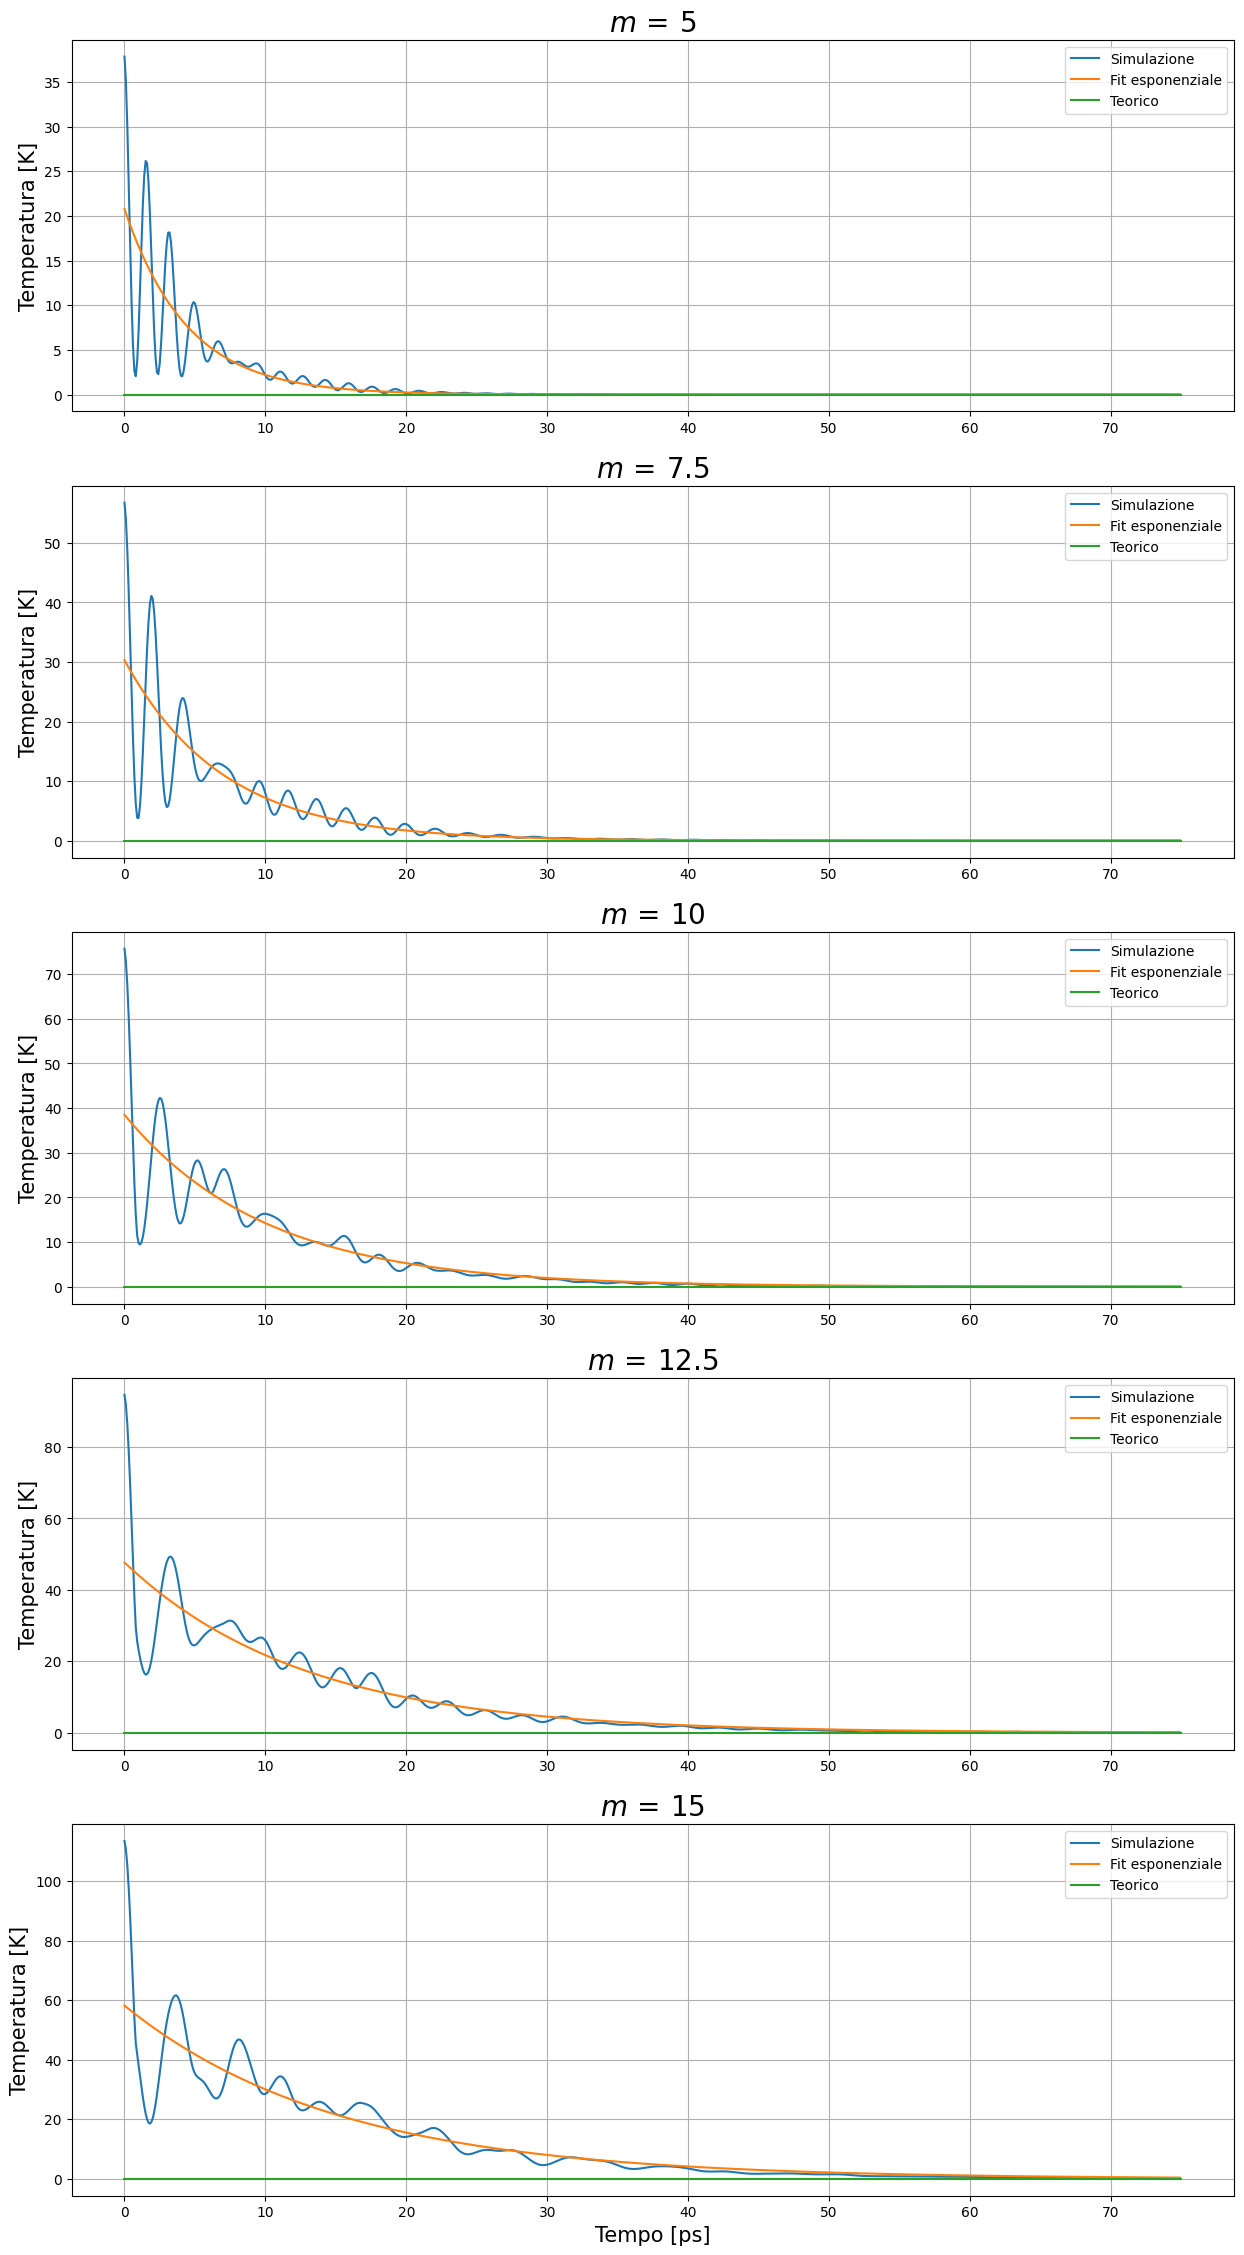

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(15, 28))
massa = np.array(['5', '7.5', '10', '12.5', '15'])
conta = -1

for i in massa:
    conta += 1
    ax = axs[conta]
    res = np.loadtxt('nullT/fit_g1-m' + i + '.out')
    ax.plot(res[0:750, 0], res[0:750, 5], label = 'Simulazione')

    #-------------------------------#
    #       Fit esponenziale        #
    #-------------------------------#
    params, covariance = curve_fit(exp_model, res[0:750, 0], res[0:750, 5])
    a = params[0]
    b = params[1]
    y_fit = exp_model(res[0:750, 0], a, b)

    print("Il fattore moltiplicativo dell'esponenziale con massa = " + i + " è pari a " + str(round(a, 3)) + " K")
    print("Il tempo caratteristico con massa = " + i + " risulta essere " + str(round(b, 3)) + " ps")
    print("")

    ax.plot(res[0:750, 0], y_fit, label = 'Fit esponenziale')
    ax.plot(np.array([res[0, 0], res[750, 0]]), np.array([0, 0]), label = 'Teorico')
    
    ax.set_ylabel(r"Temperatura [K]", fontsize = 15)
    ax.set_title(r"$m\,=\,$" + i, fontsize = 20)
    
    ax.grid(True)
    ax.legend(loc = 'best')

ax.set_xlabel(r"Tempo [ps]", fontsize = 15)
plt.show()

Per effettuare questa analisi ho campionato sia dei valori di gamma che dei valori di massa, in modo tale che queste due quantità potessero variare in

$$
\gamma \in \left\{0.5,\,0.75,\,1,\,1.25,\,1.5\right\}
$$

$$
m \in \left\{5,\,7.5,\,10,\,12.5,\,15\right\}
$$

Per riportare la totalità dei risultati ottenuti, in seguito sono presenti due surface plot, ciascuno relativo ad un parametro che compare nella funzione con cui andiamo a fittare il decadimento della temperatura.

In [8]:
massa = np.array(['5', '7.5', '10', '12.5', '15'])
gamma = np.array(['0.5', '0.75', '1', '1.25', '1.5'])
conta = -1

molt = []
tcar = []

assx = []
assy = []

for i in gamma:
    for j in massa:
        res = np.loadtxt('nullT/fit_g' + i + '-m' + j + '.out')
        params, covariance = curve_fit(exp_model, res[0:750, 0], res[0:750, 5])

        molt.append(params[0])
        tcar.append(params[1])

        assx.append(float(i))
        assy.append(float(j))

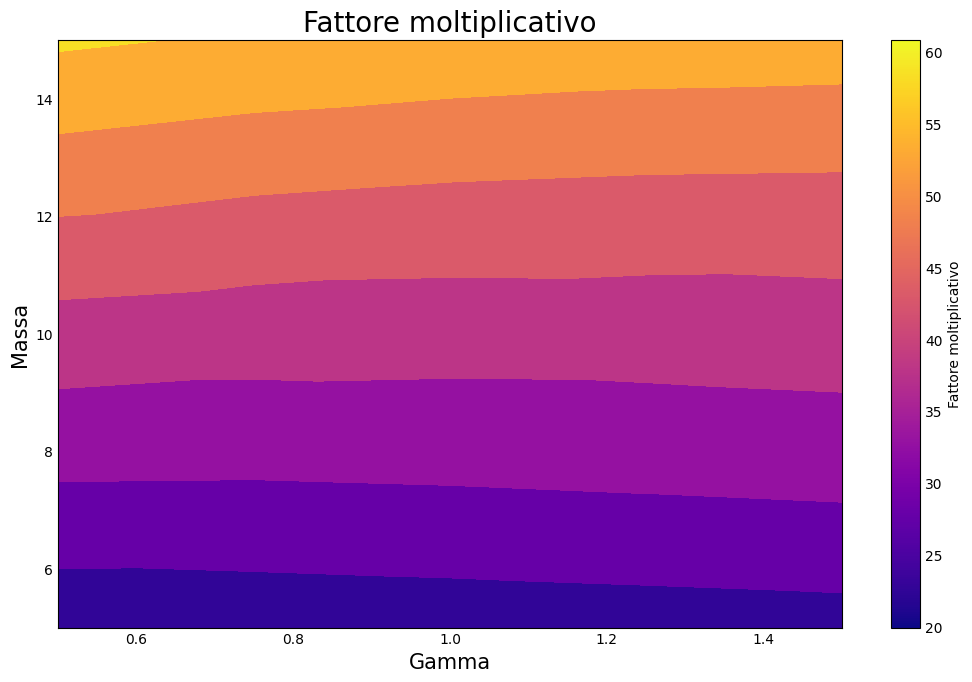

In [9]:
plt.style.use('_mpl-gallery-nogrid')

z = np.array(molt)

fig, ax = plt.subplots(figsize = (10, 6))
ax.tricontourf(assx, assy, z, cmap = 'plasma')
ax.set_xlabel(r'Gamma', fontsize = 15)
ax.set_ylabel(r'Massa', fontsize = 15)
ax.set_title(r"Fattore moltiplicativo", fontsize = 20)

sm = ScalarMappable(cmap='plasma')
sm.set_array(z)
plt.colorbar(sm, ax=ax, label='Fattore moltiplicativo')
plt.show()

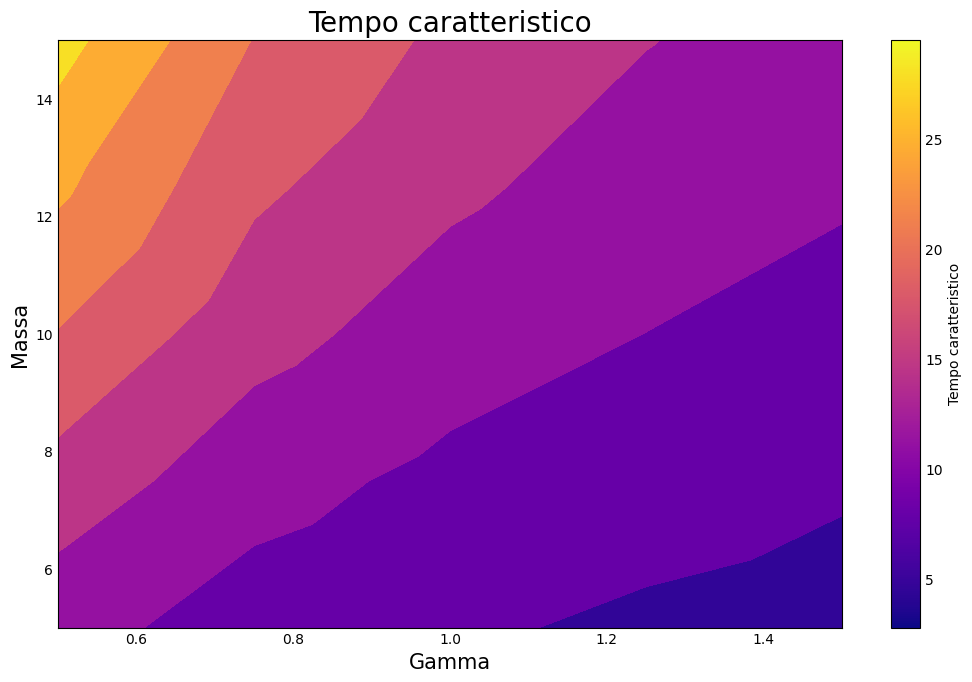

In [10]:
plt.style.use('_mpl-gallery-nogrid')

z = np.array(tcar)

fig, ax = plt.subplots(figsize = (10, 6))
ax.tricontourf(assx, assy, z, cmap = 'plasma')
ax.set_xlabel(r'Gamma', fontsize = 15)
ax.set_ylabel(r'Massa', fontsize = 15)
ax.set_title(r"Tempo caratteristico", fontsize = 20)

sm = ScalarMappable(cmap='plasma')
sm.set_array(z)
plt.colorbar(sm, ax=ax, label='Tempo caratteristico')
plt.show()

<center>
<h1 style="color:blue; font-size:50px;"> Esercizio 2.9</h1>

L'obiettivo di questo esercizio è determinare quale sia la lunghezza media della catena, ottenuta considerando differenti traiettorie nello spazio delle fasi. Per far sì che la simulazione possa campionare in modo diverso lo spazio delle fasi è necessario cambiare il contributo delle forze casuali. A livello operativo questo si può fare andando a cambiare il seed del generatore di numeri casuali, in modo tale che la sequenza generata differisca da quella ottenuta con il seed precedente. Dopo aver modificato il codice, ho scritto uno script bash _meanLen.sh_ che effettua 100 volte il cambio di seed (con conseguente simulazione), salva le medie delle singole simulazioni a file ed infine ne calcola la media. Ogni 10 simulazioni, il file di output viene salvato in modo tale da evidenziare come differenti traiettorie nello spazio delle fasi determinano anche differenti andamenti negli osservabili d'interesse.

In primo luogo mi concentro sulla temperatura delle diverse run, per valutare se la fase di termalizzazione presenti o meno una dipendeza sul seed utilizzato. Questo è necessario, perchè noi siamo interessati alla lunghezza media calcolata all'equilibrio termico, e vogliamo di conseguenza trascurare la fase di transiente.

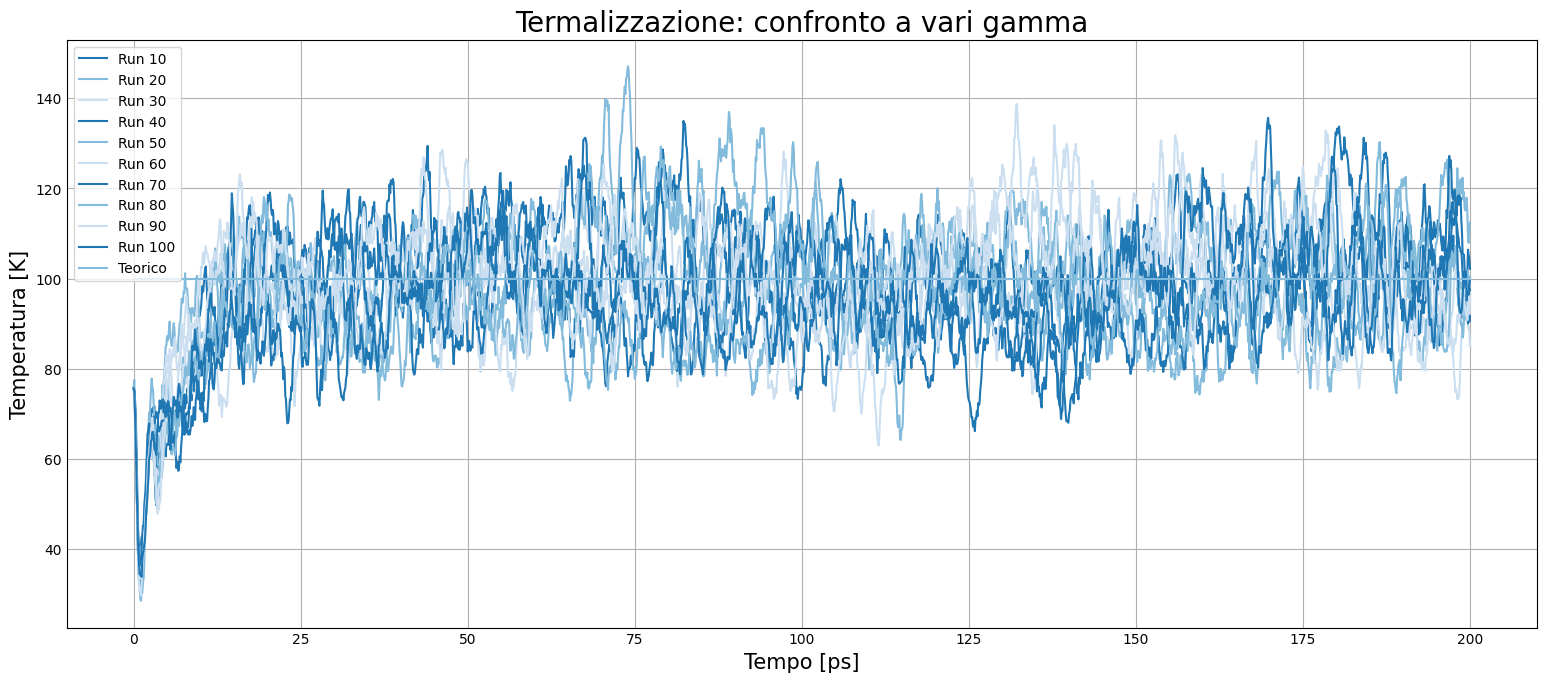

In [11]:
fig = plt.figure(figsize=(15, 6))
nrun = np.array(['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])

for i in nrun:
    res = np.loadtxt('short_chLen/output_' + i + '.dat')
    plt.plot(res[:, 0], res[:, 5], label = 'Run ' + i)

plt.plot(np.array([res[0, 0], res[-1, 0]]), np.array([100, 100]), label = 'Teorico')
plt.ylabel(r"Temperatura [K]", fontsize = 15)
plt.xlabel(r"Tempo [ps]", fontsize = 15)
plt.title(r"Termalizzazione: confronto a vari gamma", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

plt.show()

Notiamo come il transiente possa considerarsi concluso dopo circa 25 pico-secondi: quella parte di simulazione non farà parte dei dati che analizzeremo (e per questo nello script è presente un filtro sul numero di riga). Riporto ora in seguito i risultati ottenuti per la lunghezza della catena, trascurando la prima parte di dinamica.

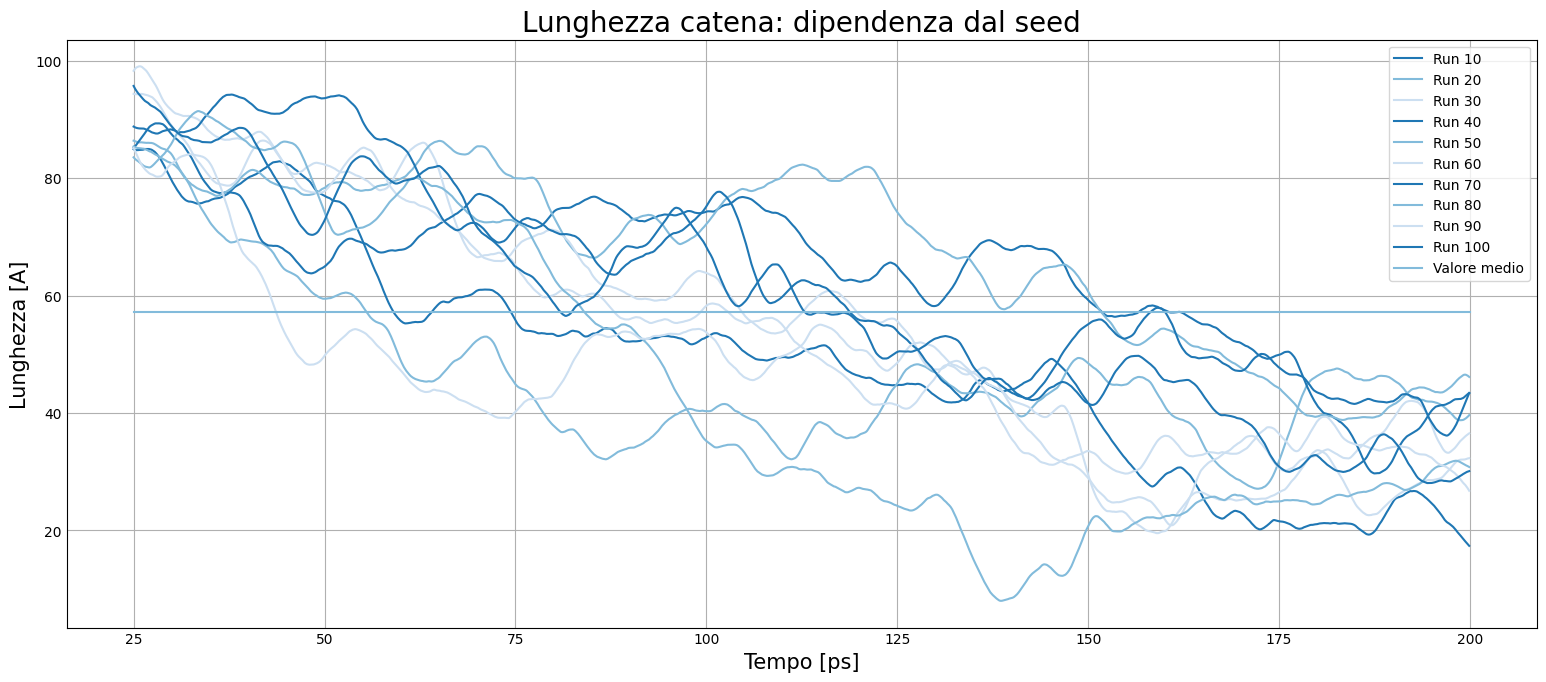

In [12]:
fig = plt.figure(figsize=(15, 6))
nrun = np.array(['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])

for i in nrun:
    res = np.loadtxt('short_chLen/output_' + i + '.dat')
    plt.plot(res[250:-1, 0], res[250:-1, 4], label = 'Run ' + i)

meanL = np.loadtxt('short_chLen/results.dat')
plt.plot(np.array([res[250, 0], res[-1, 0]]), np.array([np.mean(meanL), np.mean(meanL)]), label = 'Valore medio')
plt.ylabel(r"Lunghezza [A]", fontsize = 15)
plt.xlabel(r"Tempo [ps]", fontsize = 15)
plt.title(r"Lunghezza catena: dipendenza dal seed", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

plt.show()

Osservando il plot precedente, mi immagino che non sia corretto lavorare con soli 200 ps di evoluzione del sistema per ottenere delle informazioni significative sulla lunghezza della catena. Non abbiamo infatti oscillazioni contenute attorno ad un valor medio, ma si ha una diminuzione indicatevamente monotona della lunghezza. Per questo motivo, provo a vedere cosa accade nel caso di simulazioni della durata di 10 ns, ossia 50 volte più lunghe di quelle adesso in analisi.

La lunghezza media della catena è pari a 24.8766 A


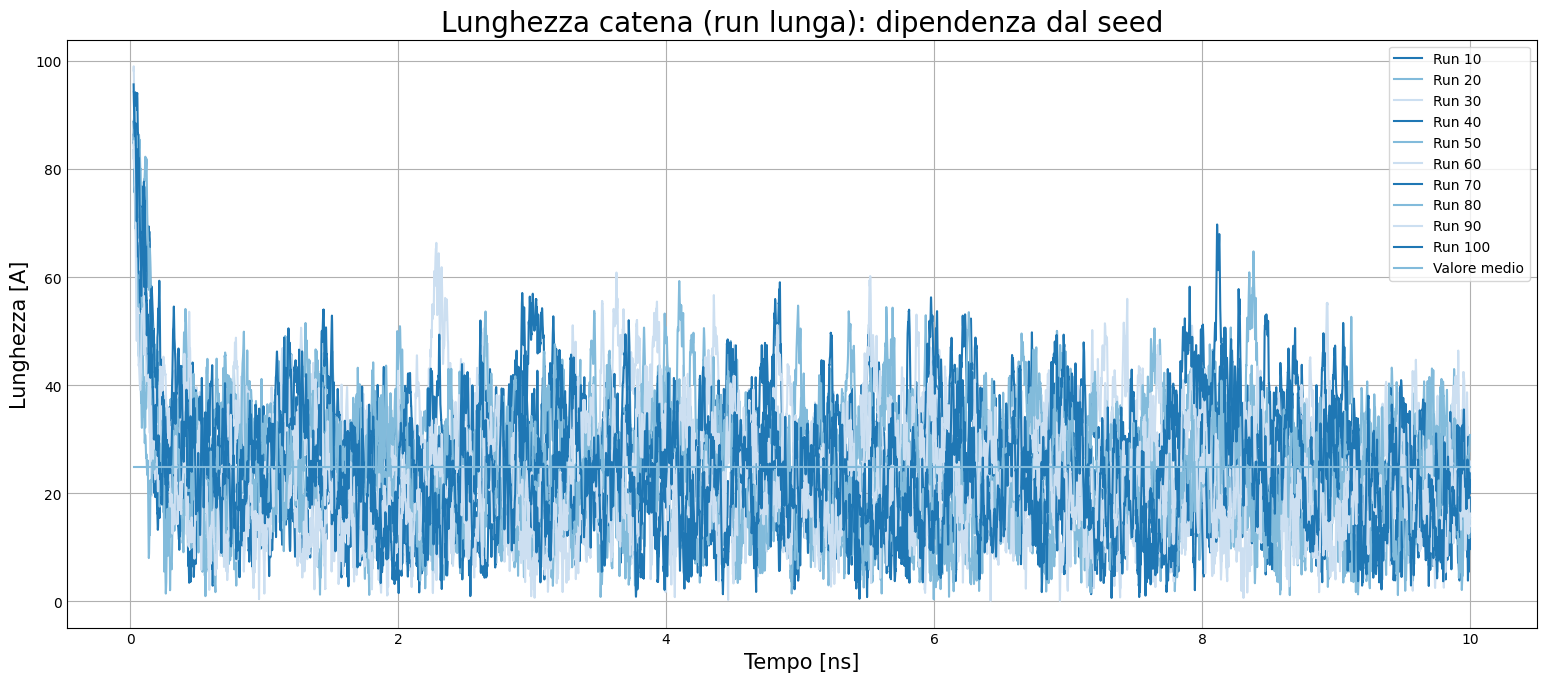

In [15]:
fig = plt.figure(figsize=(15, 6))
nrun = np.array(['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])

for i in nrun:
    res = np.loadtxt('long_chLen/output_' + i + '.dat')
    plt.plot(res[250:-1, 0]/1000, res[250:-1, 4], label = 'Run ' + i)

meanL = np.loadtxt('long_chLen/results.dat')
plt.plot(np.array([res[250, 0], res[-1, 0]])/1000, np.array([np.mean(meanL), np.mean(meanL)]), label = 'Valore medio')
plt.ylabel(r"Lunghezza [A]", fontsize = 15)
plt.xlabel(r"Tempo [ns]", fontsize = 15)
plt.title(r"Lunghezza catena (run lunga): dipendenza dal seed", fontsize = 20)
plt.grid(True)
plt.legend(loc = 'best')

print("La lunghezza media della catena è pari a " + str(round(np.mean(meanL), 4)) + " A")

plt.show()